In [1]:
# Ensure the module is automatically reloaded when rerunning the import command.
%load_ext autoreload
%autoreload 2

import pof_piv as piv
import numpy as np

In [2]:
file_prefix = None
file_type = 'png'

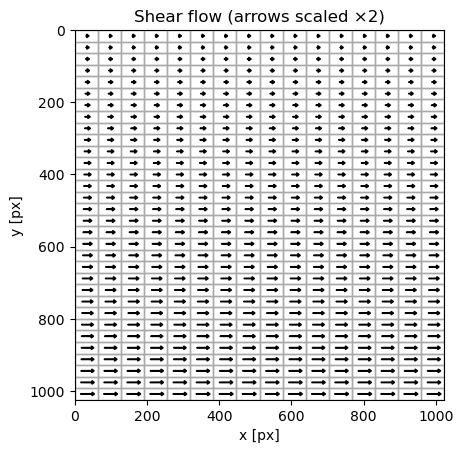

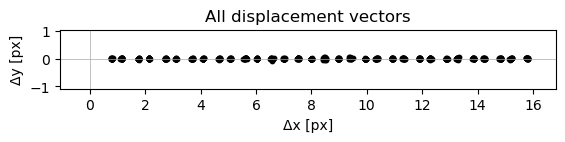

In [3]:
directory = 'PIVimages/shearflow/'
images = piv.read_image_directory(directory, file_prefix, file_type)
plot_params = {'arrow_scale':            2,
               'plot_windows':           True,
               'title':                  'Shear flow'}

displacements, coordinates = piv.simple_piv(images, (32, 64), plot=True, plt_flow_params=plot_params, plt_disp_params=plot_params)


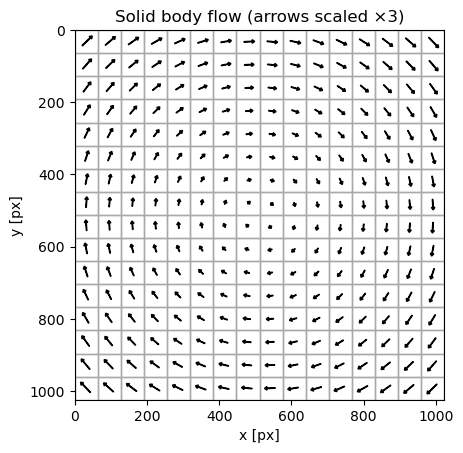

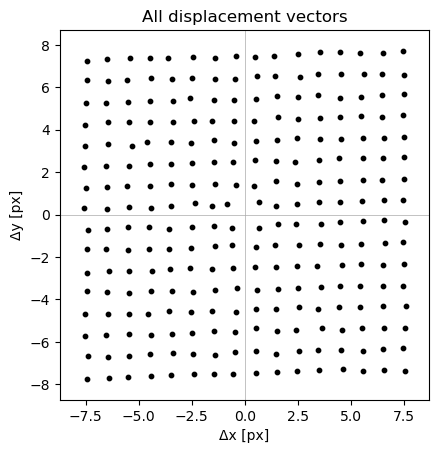

In [4]:
directory = 'PIVimages/solidbody/'
images = piv.read_image_directory(directory, file_prefix, file_type)
plot_params = {'arrow_scale':  3,
               'arrow_color':  'k',
               'plot_windows': True,
               'title':        'Solid body flow'}

displacements, coordinates = piv.simple_piv(images, 64, plot=True, plt_flow_params=plot_params, plt_disp_params=plot_params)

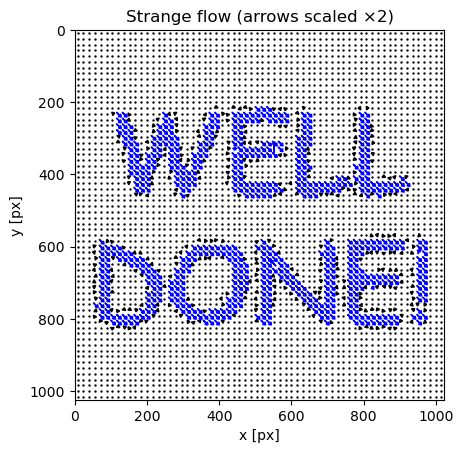

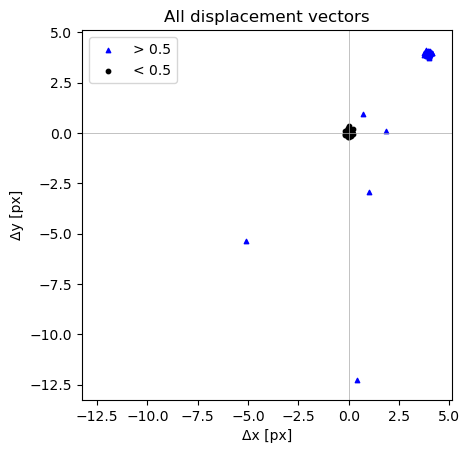

In [5]:
directory = 'PIVimages/strangeflow/'
images = piv.read_image_directory(directory, file_prefix, file_type)
plot_params = {'arrow_scale':  2,
               'zero_displ_thr': 0.01,  
               'plot_windows': False,
               'highlight_radius_range': [0.5, np.inf],
               'title':        'Strange flow',
               'legend':       ['> 0.5', '< 0.5']}

displacements, coordinates = piv.simple_piv(images, 16, plot=True,
                                            plt_flow_params=plot_params,
                                            plt_disp_params=plot_params)

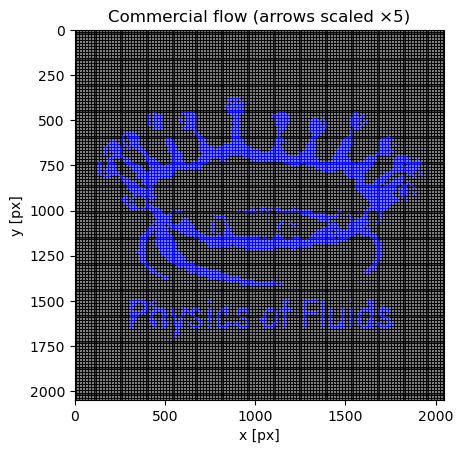

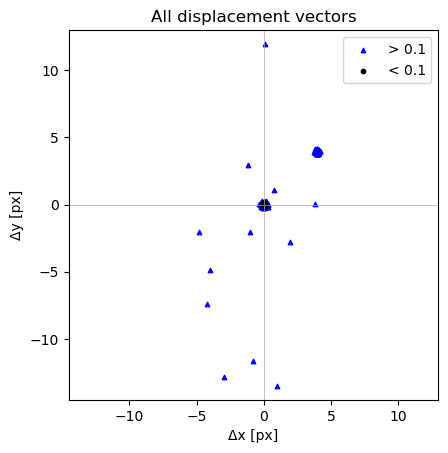

In [6]:
directory = 'PIVimages/commercialflow/'
images = piv.read_image_directory(directory, file_prefix, file_type)
plot_params = {'arrow_scale':            5,
               'plot_windows':           False,
               'zero_displ_thr':         100,
               'highlight_radius_range': [0.1, np.inf],
               'title':                  'Commercial flow',
               'legend':                 ['> 0.1', '< 0.1']}

displacements, coordinates = piv.simple_piv(images, 16, plot=True, plt_flow_params=plot_params,plt_disp_params=plot_params)